# 2 dimensional emulation

## Libraries

In [1]:
# Convenient jupyter setup
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

In [20]:
from typing import Tuple, Callable
import os
import shutil
import numpy as np
import pandas as pd
import xarray as xr
from xarray.core.utils import FrozenDict
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from adcircpy.outputs import Maxele
import imageio as io
from frozendict import frozendict
import GPy
from GPy.kern import Linear, RBF
from GPy.models import GPRegression
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.model_wrappers import SimpleGaussianProcessModel
from emukit.core import ParameterSpace, ContinuousParameter
from emukit.core.initial_designs.latin_design import LatinDesign
from emukit.model_wrappers import GPyModelWrapper
from emukit.experimental_design.acquisitions import ModelVariance
from sithom.plot import plot_defaults, label_subplots
from sithom.time import timeit
from sithom.place import Point
from sithom.misc import in_notebook
from src.constants import DATA_PATH, FIGURE_PATH
from src.models.generation import ImpactSymmetricTC, Holland08
from src.conversions import si_ify, knots_to_ms
from src.constants import NEW_ORLEANS, DATA_PATH, NO_BBOX

## 2d emulation functions

In [3]:
@np.vectorize
def indices_in_bbox(lon, lat):
    return (
        lon > NO_BBOX.lon[0]
        and lon < NO_BBOX.lon[1]
        and lat > NO_BBOX.lat[0]
        and lat < NO_BBOX.lat[1]
    )


@timeit
def func(rmax: float, folder: str, point: Point) -> float:
    output_direc = os.path.join(folder, "a" + "{:.3f}".format(rmax) + "_kat_rmax")
    if os.path.exists(output_direc):
        shutil.rmtree(output_direc)
    ImpactSymmetricTC(
        point=point,
        output_direc=output_direc,
        symetric_model=Holland08(rmax=rmax),
    ).run_impact()
    path = os.path.join(output_direc, "maxele.63.nc")
    maxele = Maxele(path, crs="EPSG:4326")
    index_set = 27
    indices = indices_in_bbox(maxele.x, maxele.y)
    return maxele.values[indices][index_set]


@timeit
def func_for_emukit() -> Callable:
    lon_diff = 0.6
    point = Point(NEW_ORLEANS.lon + lon_diff, NEW_ORLEANS.lat)
    folder = os.path.join(DATA_PATH, "kat_emulation")

    if not os.path.exists(folder):
        os.mkdir(folder)

    @np.vectorize
    def _func(rmax: float):
        return func(float(rmax), folder, point)


f = func_for_emukit()


plot_defaults()


@timeit
def twod_emulation() -> None:
    """
    Example plot.
    """

    plot_defaults()
    x_min = 12 * 1e3  # 12 km
    x_max = 50 * 1e3  # 50 km
    search_range = x_max - x_min
    plot_min, plot_max = x_min - search_range / 10, x_max + search_range / 10

    # x_data = np.random.uniform(x_min, x_max, (10, 1))
    p = ContinuousParameter("x", x_min, x_max)
    space = ParameterSpace([p])

    design = LatinDesign(space)
    num_data_points = 10
    x_data = design.get_samples(num_data_points).astype("float32")
    y_data = f(x_data)

    emukit_model = SimpleGaussianProcessModel(x_data, y_data)

    loop = ExperimentalDesignLoop(space, emukit_model)
    loop.run_loop(f, 1)

    print(x_data, y_data)

    predicted_y = []
    predicted_std = []

    real_x = np.arange(plot_min, plot_max, 1)

    for x in real_x:
        y, var = emukit_model.predict(np.array([[x]]))
        std = np.sqrt(var)
        predicted_y.append(y)
        predicted_std.append(std)

    predicted_y = np.array(predicted_y).flatten()
    predicted_std = np.array(predicted_std).flatten()
    plt.plot(real_x, predicted_y, label="estimated function", color="blue")
    plt.fill_between(
        real_x,
        predicted_y - predicted_std,
        predicted_y + predicted_std,
        color="blue",
        alpha=0.3,
    )
    plt.scatter(x_data, y_data, c="red")
    plt.scatter(
        expdesign_loop.loop_state.X[len(x_data) :],
        expdesign_loop.loop_state.Y[len(x_data) :],
        c="red",
        label="new data points",
    )
    # plt.plot(real_x, real_y, label="true function", color="red")
    plt.legend()
    plt.xlabel("Radius of Maximum Winds [m]")
    plt.ylabel("Height [m]")

    if in_notebook():
        plt.show()
    else:
        plt.clf()


# twod_emulation()

'func_for_emukit'  0.00013 s 



## Plot space graph

In [ ]:
from src.models.emulation import plot_space

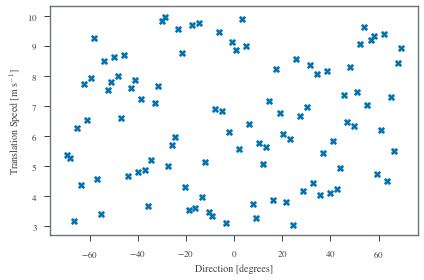

In [5]:
plot_space()

# 2d emulation

In [6]:
ls

2-dimensional-emulation.ipynb         Katrina-MakeOutput.ipynb
ERA5.ipynb                            Katrina-Mult.ipynb
Fort63.ipynb                          Katrina-Point.ipynb
Holland08.ipynb                       Katrina-Tidal-Gauges.ipynb
HollandPressure.ipynb                 Katrina-nws13.ipynb
Hurricane_Distribution.ipynb          Katrina.ipynb
Hurricane_Generator.ipynb             Question_sheet1.ipynb
Hurricane_Landing_Distribution.ipynb  Simple-Hurricane-Emulator.ipynb
IBTRACS.ipynb                         Verification.ipynb
Katrina-InputFiles.ipynb


In [3]:
def f2(a, b):
    a = a / 10
    b = b / 100
    x = np.sqrt(a**2 + b**2)
    return np.sin(x)/ x

In [14]:
np.random.seed(0)
ap = ContinuousParameter("a_param", -10 * 10 , 10 * 10)
bp = ContinuousParameter("b_param", -100 * 10, 100 * 10)
space = ParameterSpace([ap, bp])
design = LatinDesign(space)
num_data_points = 300
x_data = design.get_samples(num_data_points).astype("float32")

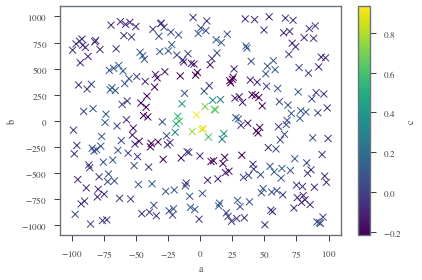

In [22]:
y_data = f2(x_data[:, 0], x_data[:, 1])
plt.scatter(x_data[:, 0], x_data[:, 1], c=y_data, marker="x")
plt.xlabel("a")
plt.ylabel("b")
plt.colorbar(label="c")

In [10]:
x_data.shape

(300, 2)

In [31]:
from GPy.kern import Linear, RBF
model_gpy = GPRegression(x_data, y_data.reshape(len(y_data), 1), RBF(2,1))
model_gpy.optimize()

In [41]:
x_data.shape

(300, 2)

In [45]:
a_indices = np.linspace(ap.min, ap.max, num=1000)
b_indices = np.linspace(bp.min, bp.max, num=1000)
a_mesh, b_mesh = np.meshgrid(a_indices, b_indices)
length = len(a_indices) * len(b_indices)
a_array = a_mesh.ravel()
b_array = b_mesh.ravel()
comb_array = np.zeros([length, 2])
comb_array[:, 0] = a_array[:]
comb_array[:, 1] = b_array[:]

In [47]:
mean, var = model_gpy.predict(comb_array)
mean_mesh = mean[:, 0].reshape(1000, 1000)
std_mesh = np.sqrt(var[:, 0]).reshape(1000, 1000)

In [50]:
mean_mesh = mean[:, 0].reshape(1000, 1000)
std_mesh = np.sqrt(var[:, 0]).reshape(1000, 1000)

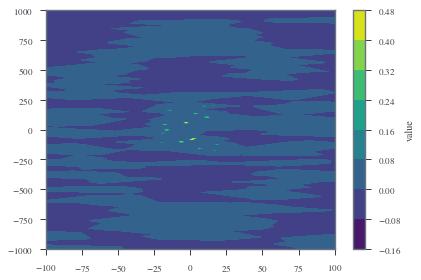

In [52]:
plt.contourf(a_mesh, b_mesh, mean_mesh)
plt.colorbar(label="value")

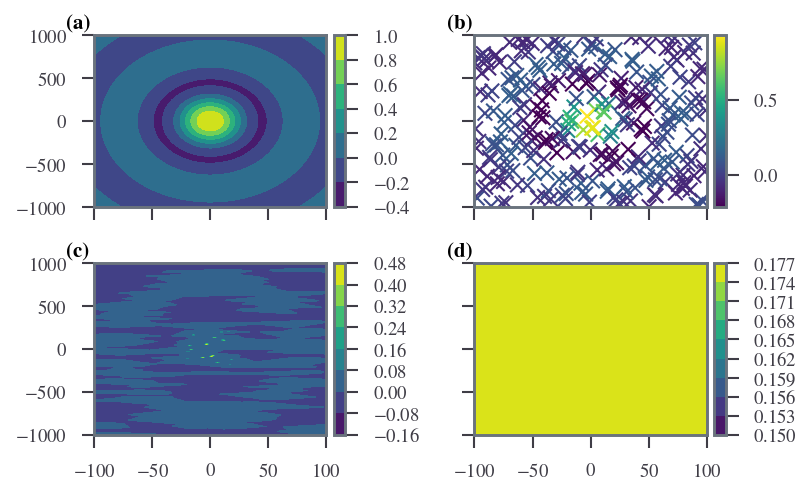

In [68]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


plot_defaults()
fig, axs = plt.subplots(2,2, sharex=True, sharey=True )

label_subplots(axs, override="outside")


y_mesh = f2(a_mesh, b_mesh)
ax = axs[0,0]
im = ax.contourf(a_mesh, b_mesh, y_mesh)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

y_data = f2(x_data[:, 0], x_data[:, 1])

ax = axs[0,1]
im = ax.scatter(x_data[:, 0], x_data[:, 1], c=y_data, marker="x")
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

ax = axs[1,0]
im = ax.contourf(a_mesh, b_mesh, mean_mesh)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

ax = axs[1,1]
im = ax.contourf(a_mesh, b_mesh, std_mesh)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

In [66]:
std_mesh.shape

(1000, 1000)

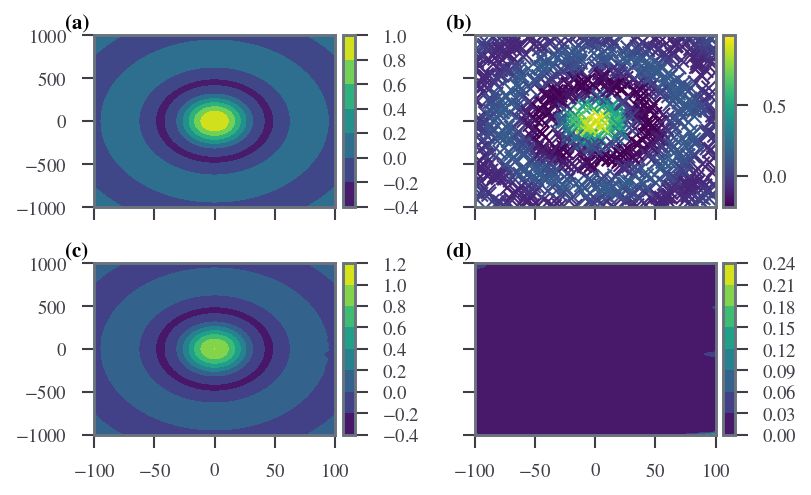

In [71]:
def more_data(num=1000):
    np.random.seed(0)
    ap = ContinuousParameter("a_param", -10 * 10 , 10 * 10)
    bp = ContinuousParameter("b_param", -100 * 10, 100 * 10)
    space = ParameterSpace([ap, bp])
    design = LatinDesign(space)
    num_data_points = num
    x_data = design.get_samples(num_data_points).astype("float32")
    y_data = f2(x_data[:, 0], x_data[:, 1])

    model_gpy = GPRegression(x_data, y_data.reshape(len(y_data), 1), RBF(2,1))
    model_gpy.optimize()

    a_indices = np.linspace(ap.min, ap.max, num=1000)
    b_indices = np.linspace(bp.min, bp.max, num=1000)
    a_mesh, b_mesh = np.meshgrid(a_indices, b_indices)
    length = len(a_indices) * len(b_indices)
    a_array = a_mesh.ravel()
    b_array = b_mesh.ravel()
    comb_array = np.zeros([length, 2])
    comb_array[:, 0] = a_array[:]
    comb_array[:, 1] = b_array[:]
    
    mean, var = model_gpy.predict(comb_array)
    mean_mesh = mean[:, 0].reshape(1000, 1000)
    std_mesh = np.sqrt(var[:, 0]).reshape(1000, 1000)


    plot_defaults()
    fig, axs = plt.subplots(2,2, sharex=True, sharey=True )

    label_subplots(axs, override="outside")
    
    y_mesh = f2(a_mesh, b_mesh)
    ax = axs[0,0]
    im = ax.contourf(a_mesh, b_mesh, y_mesh)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    y_data = f2(x_data[:, 0], x_data[:, 1])

    ax = axs[0,1]
    im = ax.scatter(x_data[:, 0], x_data[:, 1], c=y_data, marker="x")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    ax = axs[1,0]
    im = ax.contourf(a_mesh, b_mesh, mean_mesh)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    ax = axs[1,1]
    im = ax.contourf(a_mesh, b_mesh, std_mesh, vmin=-0.4, vmax=1.0)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

more_data()

In [91]:
def active_learning(init_num=150, active_num=150):
    np.random.seed(0)
    ap = ContinuousParameter("a_param", -10 * 10 , 10 * 10)
    bp = ContinuousParameter("b_param", -100 * 10, 100 * 10)
    space = ParameterSpace([ap, bp])
    design = LatinDesign(space)
    num_data_points = init_num
    x_data = design.get_samples(num_data_points).astype("float32")
    y_data = f2(x_data[:, 0], x_data[:, 1])
    
    def f3(data):
        output = f2(data[:, 0], data[:, 1])
        return output.reshape(len(output), 1)

    model_gpy = GPRegression(x_data, y_data.reshape(len(y_data), 1), RBF(2,1))
    model_gpy.optimize()
    
    # active_learning
    model_emukit = GPyModelWrapper(model_gpy)
    model_variance = ModelVariance(model=model_emukit)
    expdesign_loop = ExperimentalDesignLoop(
        model=model_emukit, space=space, acquisition=model_variance, batch_size=1
    )
    expdesign_loop.run_loop(f3, active_num)
    # var = model_variance.evaluate(real_x.reshape(len(real_x), 1))
    

    a_indices = np.linspace(ap.min, ap.max, num=1000)
    b_indices = np.linspace(bp.min, bp.max, num=1000)
    a_mesh, b_mesh = np.meshgrid(a_indices, b_indices)
    length = len(a_indices) * len(b_indices)
    a_array = a_mesh.ravel()
    b_array = b_mesh.ravel()
    comb_array = np.zeros([length, 2])
    comb_array[:, 0] = a_array[:]
    comb_array[:, 1] = b_array[:]
    
    mean, var = model_emukit.predict(comb_array)
    
    # var = model_variance.evaluate(real_x.reshape(len(real_x), 1))
    mean_mesh = mean[:, 0].reshape(1000, 1000)
    std_mesh = np.sqrt(var[:, 0]).reshape(1000, 1000)


    plot_defaults()
    fig, axs = plt.subplots(2,2, sharex=True, sharey=True )

    label_subplots(axs, override="outside")
    
    y_mesh = f2(a_mesh, b_mesh)
    ax = axs[0,0]
    im = ax.contourf(a_mesh, b_mesh, y_mesh)
    ax.set_title("True Function")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    ax = axs[0,1]
    im = ax.scatter(x_data[:, 0], 
                    x_data[:, 1], 
                    c=y_data, 
                    marker="x", 
                    label="original data points")
    ax.scatter(
        expdesign_loop.loop_state.X[len(x_data) :, 0],
        expdesign_loop.loop_state.X[len(x_data) :, 1],
        c=expdesign_loop.loop_state.Y[len(x_data) :],
        marker="+",
        label="new data points",
    )
    divider = make_axes_locatable(ax)
    ax.set_title("Samples")
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    ax = axs[1,0]
    ax.set_title("Mean Prediction")
    im = ax.contourf(a_mesh, b_mesh, mean_mesh, vmin=-0.4, vmax=1.0)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    ax = axs[1,1]
    ax.set_title("Standard Deviation")
    im = ax.contourf(a_mesh, b_mesh, std_mesh)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

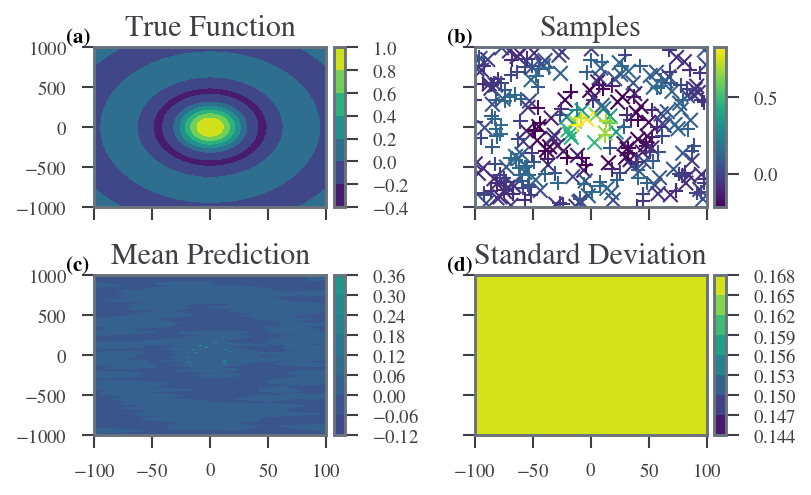

In [92]:
active_learning()

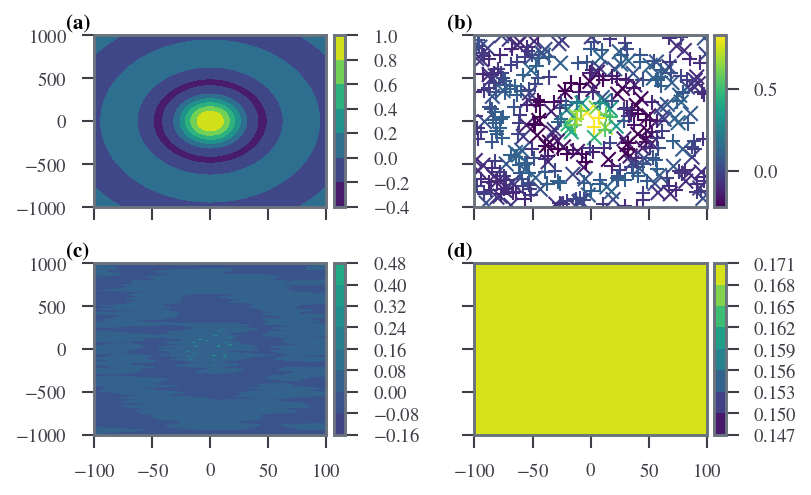

In [87]:
active_learning(init_num=150, active_num=250)

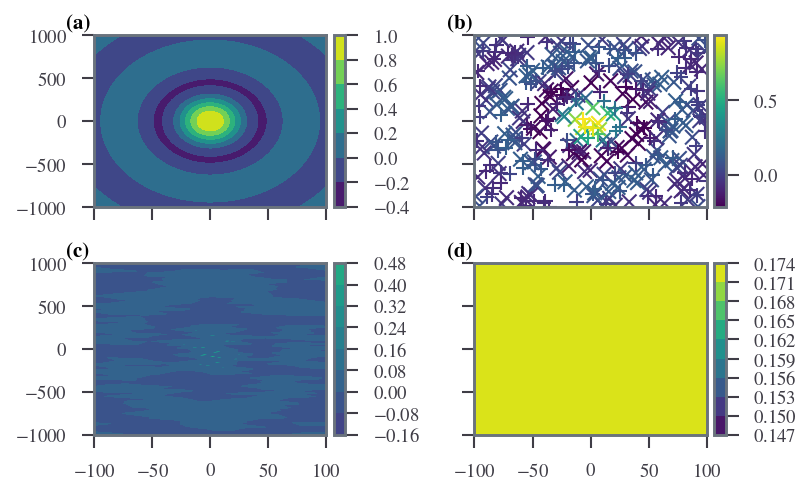

In [88]:
active_learning(init_num=250, active_num=150)

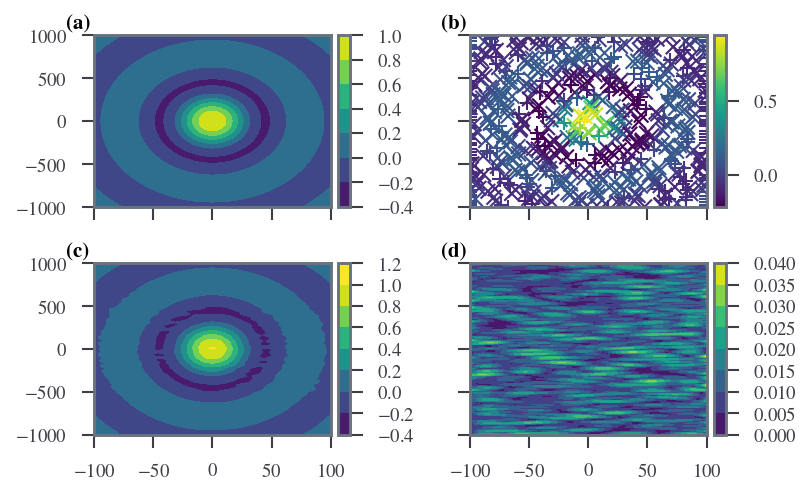

In [89]:
active_learning(init_num=400, active_num=200)

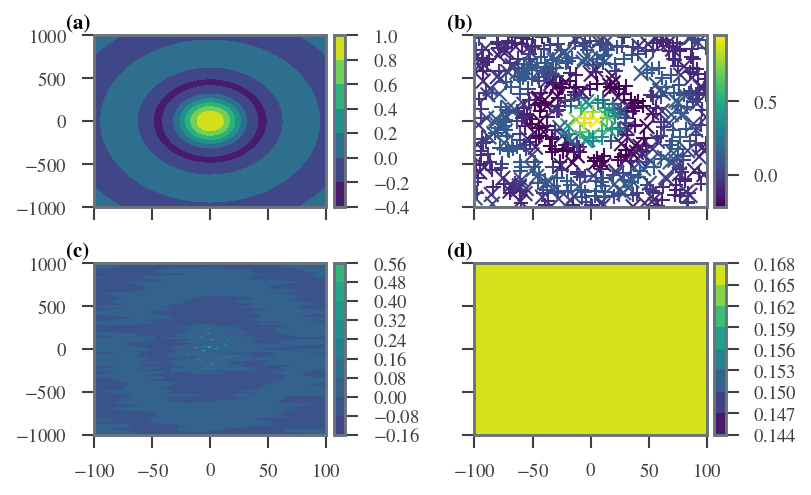

In [90]:
active_learning(init_num=200, active_num=400)

In [93]:
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement

def expected_improvement(init_num=150, active_num=150):
    np.random.seed(0)
    ap = ContinuousParameter("a_param", -10 * 10 , 10 * 10)
    bp = ContinuousParameter("b_param", -100 * 10, 100 * 10)
    space = ParameterSpace([ap, bp])
    design = LatinDesign(space)
    num_data_points = init_num
    x_data = design.get_samples(num_data_points).astype("float32")
    y_data = f2(x_data[:, 0], x_data[:, 1])
    
    def f3(data):
        output = f2(data[:, 0], data[:, 1])
        return output.reshape(len(output), 1)

    model_gpy = GPRegression(x_data, y_data.reshape(len(y_data), 1), RBF(2,1))
    model_gpy.optimize()
    
    # active_learning
    model_emukit = GPyModelWrapper(model_gpy)
    model_variance = ExpectedImprovement(model=model_emukit)
    expdesign_loop = ExperimentalDesignLoop(
        model=model_emukit, space=space, acquisition=model_variance, batch_size=1
    )
    expdesign_loop.run_loop(f3, active_num)
    # var = model_variance.evaluate(real_x.reshape(len(real_x), 1))
    

    a_indices = np.linspace(ap.min, ap.max, num=1000)
    b_indices = np.linspace(bp.min, bp.max, num=1000)
    a_mesh, b_mesh = np.meshgrid(a_indices, b_indices)
    length = len(a_indices) * len(b_indices)
    a_array = a_mesh.ravel()
    b_array = b_mesh.ravel()
    comb_array = np.zeros([length, 2])
    comb_array[:, 0] = a_array[:]
    comb_array[:, 1] = b_array[:]
    
    mean, var = model_emukit.predict(comb_array)
    
    # var = model_variance.evaluate(real_x.reshape(len(real_x), 1))
    mean_mesh = mean[:, 0].reshape(1000, 1000)
    std_mesh = np.sqrt(var[:, 0]).reshape(1000, 1000)


    plot_defaults()
    fig, axs = plt.subplots(2,2, sharex=True, sharey=True )

    label_subplots(axs, override="outside")
    
    y_mesh = f2(a_mesh, b_mesh)
    ax = axs[0,0]
    im = ax.contourf(a_mesh, b_mesh, y_mesh)
    ax.set_title("True Function")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    ax = axs[0,1]
    im = ax.scatter(x_data[:, 0], 
                    x_data[:, 1], 
                    c=y_data, 
                    marker="x", 
                    label="original data points")
    ax.scatter(
        expdesign_loop.loop_state.X[len(x_data) :, 0],
        expdesign_loop.loop_state.X[len(x_data) :, 1],
        c=expdesign_loop.loop_state.Y[len(x_data) :],
        marker="+",
        label="new data points",
    )
    divider = make_axes_locatable(ax)
    ax.set_title("Samples")
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    ax = axs[1,0]
    ax.set_title("Mean Prediction")
    im = ax.contourf(a_mesh, b_mesh, mean_mesh, vmin=-0.4, vmax=1.0)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    ax = axs[1,1]
    ax.set_title("Standard Deviation")
    im = ax.contourf(a_mesh, b_mesh, std_mesh)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

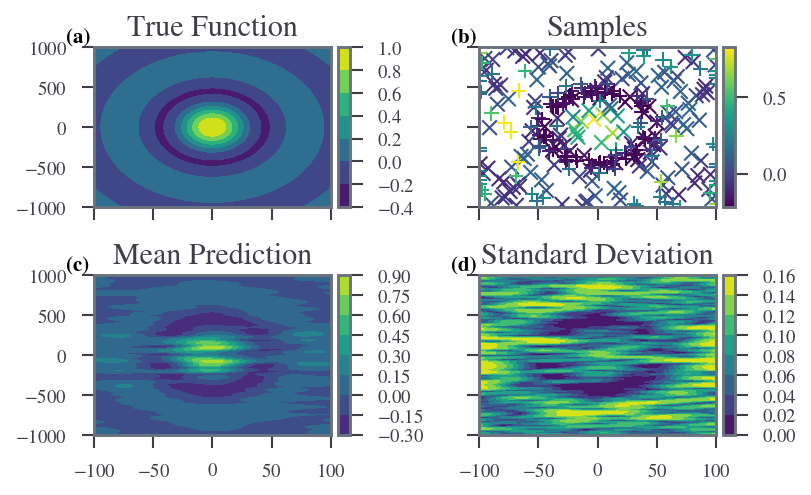

In [94]:
expected_improvement()

In [27]:
class Emulation:
    def __init__(self, seed=0, init_num=200, active_num=200, indices=100) -> None:
        self.seed = seed
        np.random.seed(seed)
        self.ap = ContinuousParameter("a_param", -10 * 10, 10 * 10)
        self.bp = ContinuousParameter("b_param", -100 * 10, 100 * 10)
        self.space = ParameterSpace([self.ap, self.bp])
        self.design = LatinDesign(self.space)
        self.init_num = init_num
        self.active_num = active_num
        self.init_x_data = self.design.get_samples(self.init_num).astype("float32")
        self.init_y_data = self.func(self.init_x_data)
        self.model_gpy = GPRegression(
            self.init_x_data,
            self.init_y_data.reshape(len(self.init_y_data), 1),
            RBF(2, 1),
        )
        self.model_gpy.optimize()

        # active_learning
        self.model_emukit = GPyModelWrapper(self.model_gpy)
        self.acquisition_function = ExpectedImprovement(model=self.model_emukit)
        self.expdesign_loop = ExperimentalDesignLoop(
            model=self.model_emukit,
            space=self.space,
            acquisition=self.acquisition_function,
            batch_size=1,
        )
        self.expdesign_loop.run_loop(self.func, active_num)
        self.active_x_data = self.expdesign_loop.loop_state.X[len(self.init_x_data) :]
        self.active_y_data = self.expdesign_loop.loop_state.Y[len(self.init_x_data) :]
        self.indices = indices

    def __repr__(self) -> str:
        return f"seed = {self.seed}, init_num = {self.init_num}, active_num = {self.active_num}"

    def func(self, data: np.ndarray) -> np.ndarray:
        output = f2(data[:, 0], data[:, 1])
        return output.reshape(len(output), 1)

    def func_mesh(self, data: np.ndarray) -> np.ndarray:
        shape = np.shape(data)
        print(shape)
        output = self.func(data.reshape(shape[0] * shape[1], 2))
        return output.reshape(shape[0], shape[1], 2)

    def plot(self) -> None:
        a_indices = np.linspace(self.ap.min, self.ap.max, num=self.indices)
        b_indices = np.linspace(self.bp.min, self.bp.max, num=self.indices)
        a_mesh, b_mesh = np.meshgrid(a_indices, b_indices)
        length = len(a_indices) * len(b_indices)
        a_array = a_mesh.ravel()
        b_array = b_mesh.ravel()
        comb_array = np.zeros([length, 2])
        comb_array[:, 0] = a_array[:]
        comb_array[:, 1] = b_array[:]

        y_mesh = self.func(comb_array).reshape(self.indices, self.indices)
        mean, var = self.model_emukit.predict(comb_array)
        mean_mesh = mean[:, 0].reshape(self.indices, self.indices)
        std_mesh = np.sqrt(var[:, 0]).reshape(self.indices, self.indices)

        plot_defaults()
        fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

        label_subplots(axs, override="outside")


        ax = axs[0, 0]
        im = ax.contourf(a_mesh, b_mesh, y_mesh)
        ax.set_title("True Function")
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax, orientation="vertical")

        ax = axs[0, 1]
        im = ax.scatter(
            self.init_x_data[:, 0],
            self.init_x_data[:, 1],
            c=self.init_y_data,
            marker="x",
            label="original data points",
        )
        ax.scatter(
            self.active_x_data[:, 0],
            self.active_x_data[:, 1],
            c=self.active_y_data,
            marker="+",
            label="new data points",
        )
        divider = make_axes_locatable(ax)
        ax.set_title("Samples")
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax, orientation="vertical")

        ax = axs[1, 0]
        ax.set_title("Mean Prediction")
        im = ax.contourf(a_mesh, b_mesh, mean_mesh, vmin=-0.4, vmax=1.0)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax, orientation="vertical")

        ax = axs[1, 1]
        ax.set_title("Standard Deviation")
        im = ax.contourf(a_mesh, b_mesh, std_mesh)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax, orientation="vertical")
        plt.show()

In [28]:
em = Emulation(init_num=100, active_num=50)

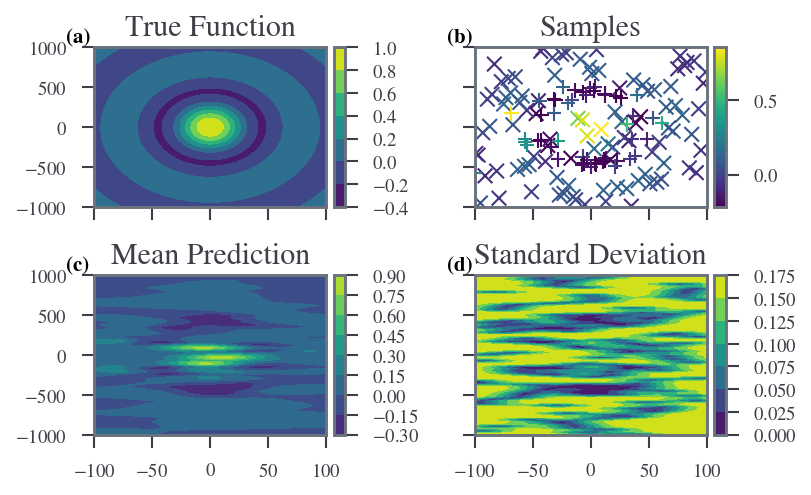

In [29]:
em.plot()

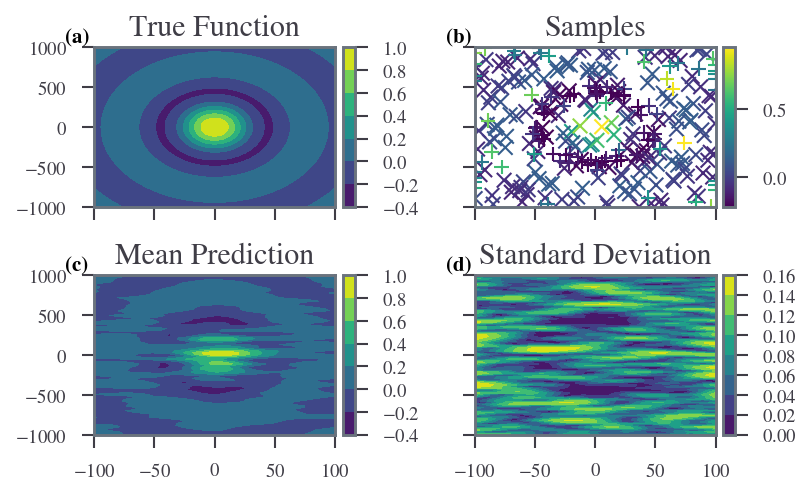

In [30]:
em = Emulation(init_num=200, active_num=100)
em.plot()

In [119]:
npz = np.zeros((1000, 2))
print(npz.shape)

(1000, 2)


In [121]:
npz[:,  0] = 1
npzs = npz.reshape(10, 100, 2)

In [123]:
np.all(1 == npzs[:, :, 0])

True

In [124]:
np.all(0 == npzs[:, :, 1])

True

In [125]:
npzf = npzs.reshape(1000, 2)

In [126]:
np.all(npzf[:, 0] == 1)

True

In [127]:
np.all(npzf[:, 1] == 0)

True

In [128]:
np.all(npzf[:, 0] == 0)

False

In [114]:
em.init_x_data

array([[ 3.75e+01, -5.45e+02],
       [ 4.25e+01, -2.95e+02],
       [-3.85e+01, -7.15e+02],
       [ 4.15e+01,  8.75e+02],
       [ 4.55e+01, -5.55e+02],
       [ 5.05e+01, -7.25e+02],
       [ 6.35e+01, -4.25e+02],
       [-5.95e+01, -6.85e+02],
       [-8.65e+01,  3.75e+02],
       [-1.45e+01, -8.75e+02],
       [ 5.85e+01,  9.95e+02],
       [-7.75e+01,  4.95e+02],
       [-6.95e+01, -8.15e+02],
       [-8.35e+01, -1.45e+02],
       [-5.00e-01,  7.15e+02],
       [-8.55e+01, -8.55e+02],
       [ 9.35e+01, -4.15e+02],
       [ 8.95e+01, -5.75e+02],
       [ 6.65e+01,  9.05e+02],
       [-4.50e+00, -2.25e+02],
       [ 3.50e+00, -4.95e+02],
       [ 7.95e+01,  8.50e+01],
       [-9.15e+01, -5.35e+02],
       [-4.05e+01, -1.25e+02],
       [-8.50e+00,  3.45e+02],
       [ 6.50e+00,  9.25e+02],
       [ 9.05e+01, -1.05e+02],
       [-4.45e+01,  2.65e+02],
       [ 8.05e+01,  6.35e+02],
       [-6.85e+01, -7.45e+02],
       [ 6.85e+01, -4.75e+02],
       [-3.25e+01,  7.55e+02],
       [

In [115]:
em.init_y_data

array([[ 4.93148826e-02],
       [-1.73106179e-01],
       [ 1.18790165e-01],
       [-2.64951270e-02],
       [ 1.08584516e-01],
       [ 6.29070029e-02],
       [ 1.27915934e-01],
       [ 3.79435606e-02],
       [-3.29462695e-04],
       [ 5.94548248e-02],
       [-7.40081146e-02],
       [ 2.46699154e-02],
       [-8.96066278e-02],
       [ 9.59659368e-02],
       [ 1.06624544e-01],
       [-3.78116220e-02],
       [-7.04539940e-02],
       [-8.80544484e-02],
       [-8.65962654e-02],
       [ 3.26563656e-01],
       [-1.95253968e-01],
       [ 1.23826288e-01],
       [-8.70343298e-02],
       [-2.09933639e-01],
       [-1.12590589e-01],
       [ 1.63255502e-02],
       [ 3.39086503e-02],
       [-1.72411710e-01],
       [-7.18579218e-02],
       [-6.33324757e-02],
       [ 1.06309250e-01],
       [ 1.13607928e-01],
       [ 6.82757189e-03],
       [-7.97870979e-02],
       [-2.14963824e-01],
       [-1.15012443e-02],
       [-1.73753370e-02],
       [-8.52526873e-02],
       [ 6.7

In [116]:
em

seed = 0

In [31]:
class EmulationVary:
    def __init__(self, seed=0, 
                 init_num=200, 
                 active_num=200, 
                 indices=100,
                 acqusition_class=ExpectedImprovement,
                 loop_class= ExperimentalDesignLoop,
                ) -> None:
        self.seed = seed
        np.random.seed(seed)
        self.ap = ContinuousParameter("a_param", -10 * 10, 10 * 10)
        self.bp = ContinuousParameter("b_param", -100 * 10, 100 * 10)
        self.space = ParameterSpace([self.ap, self.bp])
        self.design = LatinDesign(self.space)
        self.init_num = init_num
        self.active_num = active_num
        self.init_x_data = self.design.get_samples(self.init_num).astype("float32")
        self.init_y_data = self.func(self.init_x_data)
        self.model_gpy = GPRegression(
            self.init_x_data,
            self.init_y_data.reshape(len(self.init_y_data), 1),
            RBF(2, 1),
        )
        self.model_gpy.optimize()

        # active_learning
        self.model_emukit = GPyModelWrapper(self.model_gpy)
        self.acquisition_function = acqusition_class(model=self.model_emukit)
        self.loop = loop_class(
            model=self.model_emukit,
            space=self.space,
            acquisition=self.acquisition_function,
            batch_size=1,
        )
        self.loop.run_loop(self.func, active_num)
        self.active_x_data = self.loop.loop_state.X[len(self.init_x_data) :]
        self.active_y_data = self.loop.loop_state.Y[len(self.init_x_data) :]
        self.indices = indices

    def __repr__(self) -> str:
        return f"seed = {self.seed}, init_num = {self.init_num}, active_num = {self.active_num}"

    def func(self, data: np.ndarray) -> np.ndarray:
        output = f2(data[:, 0], data[:, 1])
        return output.reshape(len(output), 1)

    def func_mesh(self, data: np.ndarray) -> np.ndarray:
        shape = np.shape(data)
        print(shape)
        output = self.func(data.reshape(shape[0] * shape[1], 2))
        return output.reshape(shape[0], shape[1], 2)

    def plot(self) -> None:
        a_indices = np.linspace(self.ap.min, self.ap.max, num=self.indices)
        b_indices = np.linspace(self.bp.min, self.bp.max, num=self.indices)
        a_mesh, b_mesh = np.meshgrid(a_indices, b_indices)
        length = len(a_indices) * len(b_indices)
        a_array = a_mesh.ravel()
        b_array = b_mesh.ravel()
        comb_array = np.zeros([length, 2])
        comb_array[:, 0] = a_array[:]
        comb_array[:, 1] = b_array[:]

        y_mesh = self.func(comb_array).reshape(self.indices, self.indices)
        mean, var = self.model_emukit.predict(comb_array)
        mean_mesh = mean[:, 0].reshape(self.indices, self.indices)
        std_mesh = np.sqrt(var[:, 0]).reshape(self.indices, self.indices)

        plot_defaults()
        fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

        label_subplots(axs, override="outside")


        ax = axs[0, 0]
        im = ax.contourf(a_mesh, b_mesh, y_mesh)
        ax.set_title("True Function")
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax, orientation="vertical")

        ax = axs[0, 1]
        im = ax.scatter(
            self.init_x_data[:, 0],
            self.init_x_data[:, 1],
            c=self.init_y_data,
            marker="x",
            label="original data points",
        )
        ax.scatter(
            self.active_x_data[:, 0],
            self.active_x_data[:, 1],
            c=self.active_y_data,
            marker="+",
            label="new data points",
        )
        divider = make_axes_locatable(ax)
        ax.set_title("Samples")
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax, orientation="vertical")

        ax = axs[1, 0]
        ax.set_title("Mean Prediction")
        im = ax.contourf(a_mesh, b_mesh, mean_mesh, vmin=-0.4, vmax=1.0)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax, orientation="vertical")

        ax = axs[1, 1]
        ax.set_title("Standard Deviation")
        im = ax.contourf(a_mesh, b_mesh, std_mesh)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax, orientation="vertical")
        plt.show()

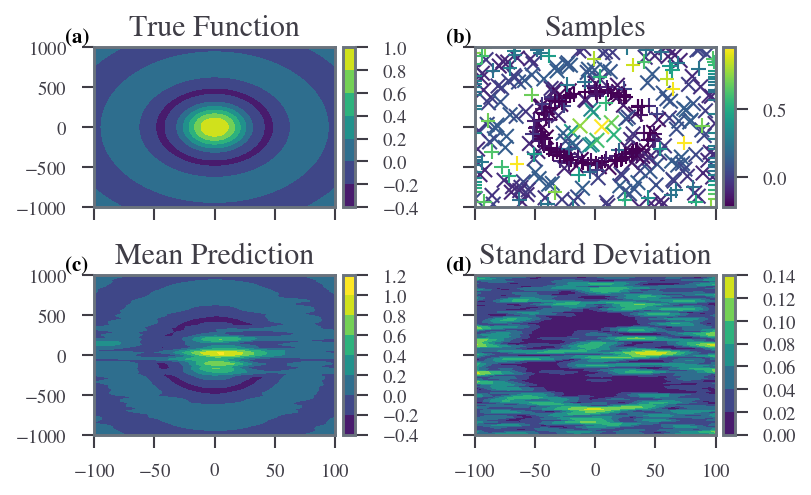

In [32]:
emd = EmulationVary()
emd.plot()

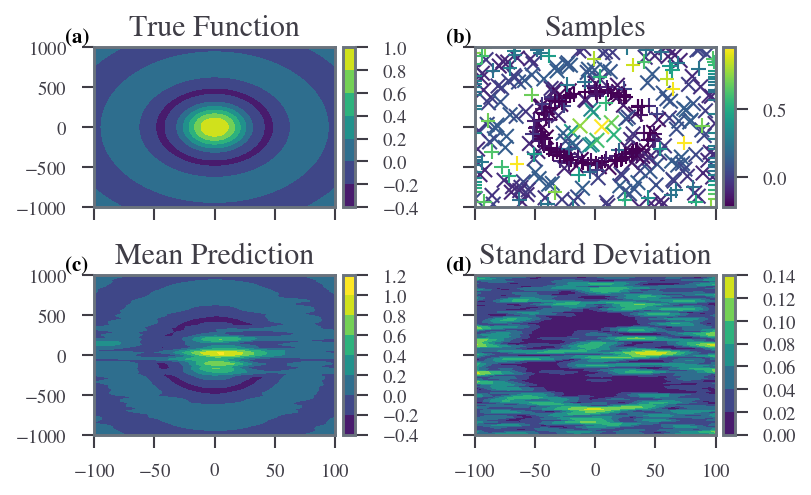

In [34]:
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
emd = EmulationVary(loop_class=BayesianOptimizationLoop)
emd.plot()

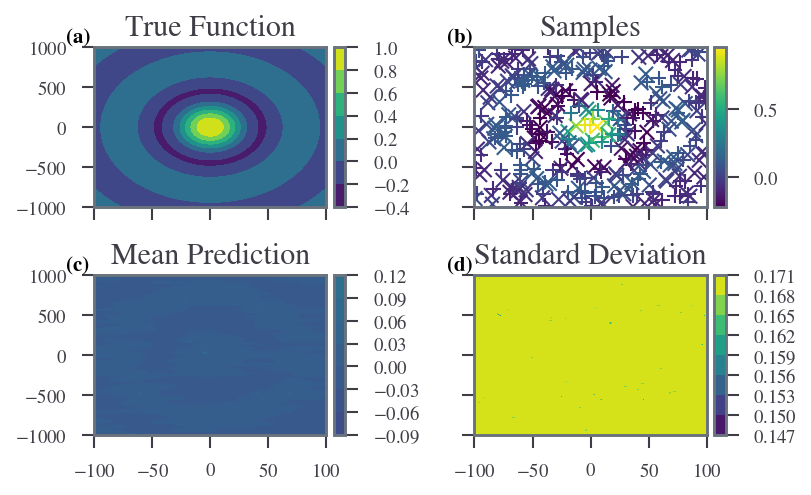

In [35]:
emd = EmulationVary(acqusition_class=ModelVariance,loop_class=BayesianOptimizationLoop)
emd.plot()

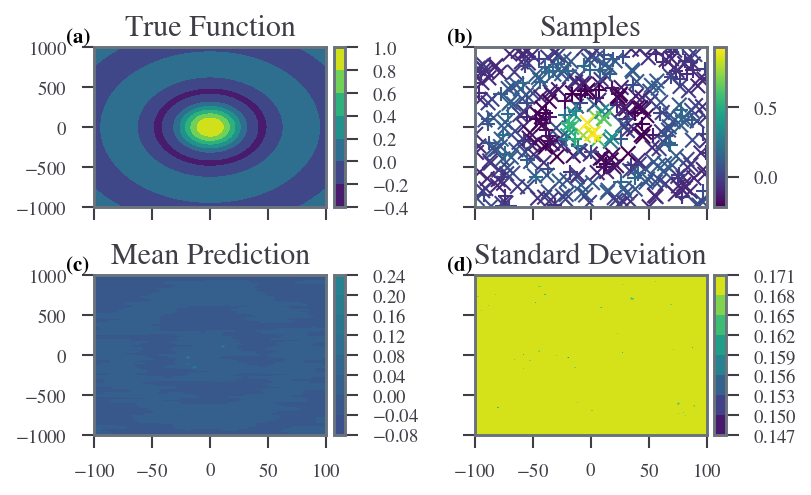

In [36]:
emd = EmulationVary(init_num=400, active_num=100, acqusition_class=ModelVariance, loop_class=BayesianOptimizationLoop)
emd.plot()

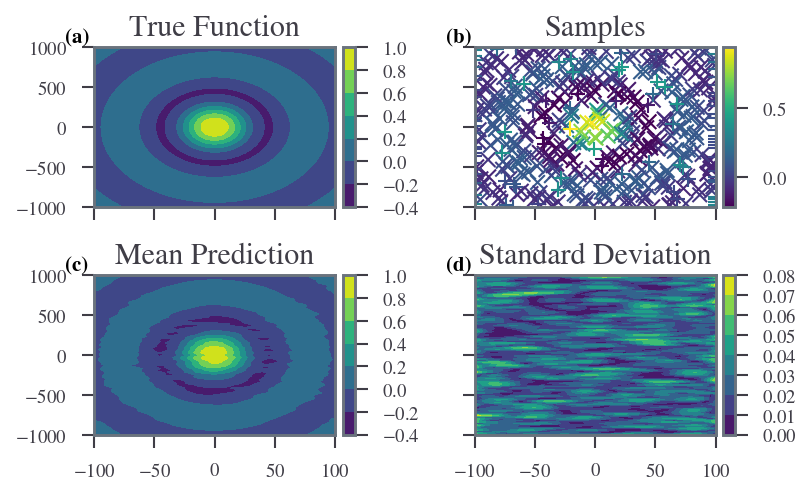

In [37]:
emd = EmulationVary(init_num=400, active_num=100, acqusition_class=ModelVariance, loop_class=ExperimentalDesignLoop)
emd.plot()

In [40]:
class EmulationPreprocess:
    def __init__(self, seed=0, 
                 init_num=200, 
                 active_num=200, 
                 indices=100,
                 acqusition_class=ExpectedImprovement,
                 loop_class= ExperimentalDesignLoop,
                ) -> None:
        self.seed = seed
        np.random.seed(seed)
        self.ap = ContinuousParameter("a_param", -10 * 10, 10 * 10)
        self.bp = ContinuousParameter("b_param", -10 * 10, 10 * 10)
        self.space = ParameterSpace([self.ap, self.bp])
        self.design = LatinDesign(self.space)
        self.init_num = init_num
        self.active_num = active_num
        self.init_x_data = self.design.get_samples(self.init_num).astype("float32")
        self.init_y_data = self.func(self.init_x_data)
        self.model_gpy = GPRegression(
            self.init_x_data,
            self.init_y_data.reshape(len(self.init_y_data), 1),
            RBF(2, 1),
        )
        self.model_gpy.optimize()

        # active_learning
        self.model_emukit = GPyModelWrapper(self.model_gpy)
        self.acquisition_function = acqusition_class(model=self.model_emukit)
        self.loop = loop_class(
            model=self.model_emukit,
            space=self.space,
            acquisition=self.acquisition_function,
            batch_size=1,
        )
        self.loop.run_loop(self.func, active_num)
        self.active_x_data = self.loop.loop_state.X[len(self.init_x_data) :]
        self.active_y_data = self.loop.loop_state.Y[len(self.init_x_data) :]
        self.indices = indices

    def __repr__(self) -> str:
        return f"seed = {self.seed}, init_num = {self.init_num}, active_num = {self.active_num}"

    def func(self, data: np.ndarray) -> np.ndarray:
        output = f2(data[:, 0], data[:, 1] * 10)
        return output.reshape(len(output), 1)        

    def func_mesh(self, data: np.ndarray) -> np.ndarray:
        shape = np.shape(data)
        print(shape)
        output = self.func(data.reshape(shape[0] * shape[1], 2))
        return output.reshape(shape[0], shape[1], 2)

    def plot(self) -> None:
        a_indices = np.linspace(self.ap.min, self.ap.max, num=self.indices)
        b_indices = np.linspace(self.bp.min, self.bp.max, num=self.indices)
        a_mesh, b_mesh = np.meshgrid(a_indices, b_indices)
        length = len(a_indices) * len(b_indices)
        a_array = a_mesh.ravel()
        b_array = b_mesh.ravel()
        comb_array = np.zeros([length, 2])
        comb_array[:, 0] = a_array[:]
        comb_array[:, 1] = b_array[:]

        y_mesh = self.func(comb_array).reshape(self.indices, self.indices)
        mean, var = self.model_emukit.predict(comb_array)
        mean_mesh = mean[:, 0].reshape(self.indices, self.indices)
        std_mesh = np.sqrt(var[:, 0]).reshape(self.indices, self.indices)

        plot_defaults()
        fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
        label_subplots(axs, override="outside")


        ax = axs[0, 0]
        im = ax.contourf(a_mesh, b_mesh, y_mesh)
        ax.set_title("True Function")
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax, orientation="vertical")

        ax = axs[0, 1]
        im = ax.scatter(
            self.init_x_data[:, 0],
            self.init_x_data[:, 1],
            c=self.init_y_data,
            marker="x",
            label="original data points",
        )
        ax.scatter(
            self.active_x_data[:, 0],
            self.active_x_data[:, 1],
            c=self.active_y_data,
            marker="+",
            label="new data points",
        )
        divider = make_axes_locatable(ax)
        ax.set_title("Samples")
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax, orientation="vertical")

        ax = axs[1, 0]
        ax.set_title("Mean Prediction")
        im = ax.contourf(a_mesh, b_mesh, mean_mesh, vmin=-0.4, vmax=1.0)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax, orientation="vertical")

        ax = axs[1, 1]
        ax.set_title("Standard Deviation")
        im = ax.contourf(a_mesh, b_mesh, std_mesh)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax, orientation="vertical")
        plt.show()

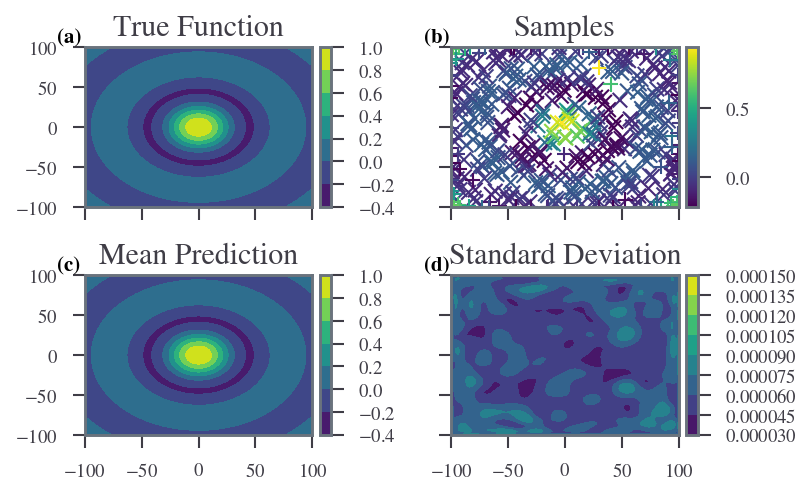

In [41]:
emp = EmulationPreprocess(init_num=400, active_num=100, acqusition_class=ModelVariance, loop_class=ExperimentalDesignLoop)
emp.plot()

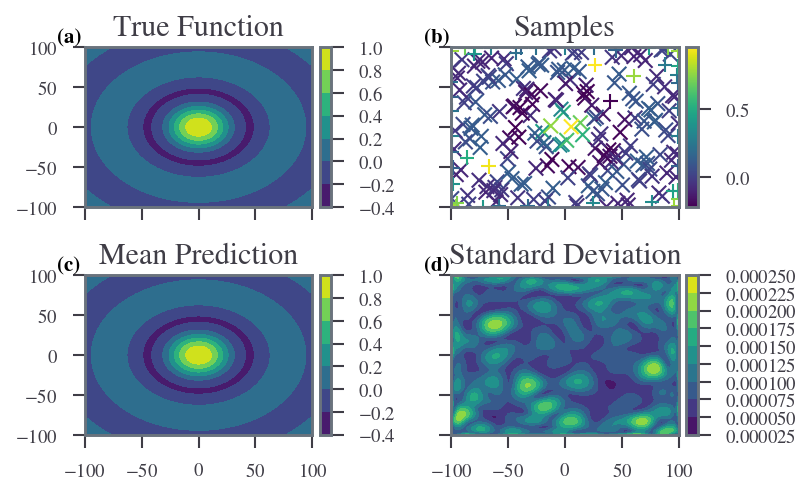

In [42]:
emp = EmulationPreprocess(init_num=200, 
                          active_num=50,
                          acqusition_class=ModelVariance,
                          loop_class=ExperimentalDesignLoop)
emp.plot()

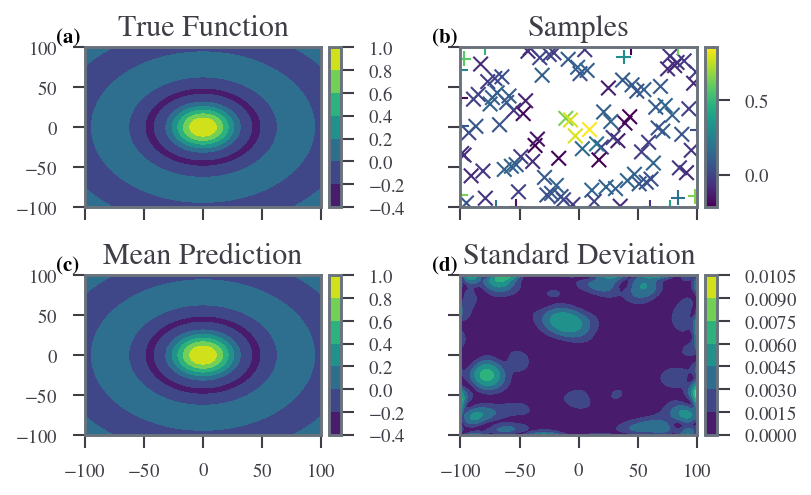

In [43]:
emp = EmulationPreprocess(init_num=100, 
                          active_num=20,
                          acqusition_class=ModelVariance,
                          loop_class=ExperimentalDesignLoop)
emp.plot()

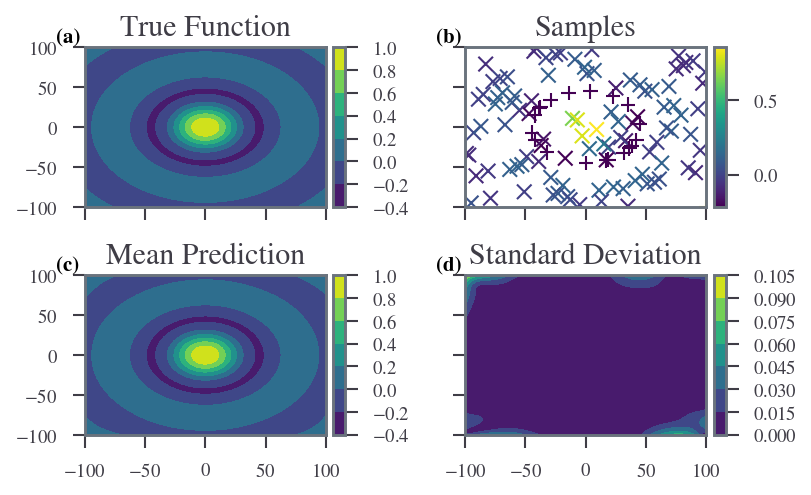

In [45]:
emp = EmulationPreprocess(init_num=100, 
                          active_num=20,
                          acqusition_class=ExpectedImprovement,
                          loop_class=BayesianOptimizationLoop)
emp.plot()

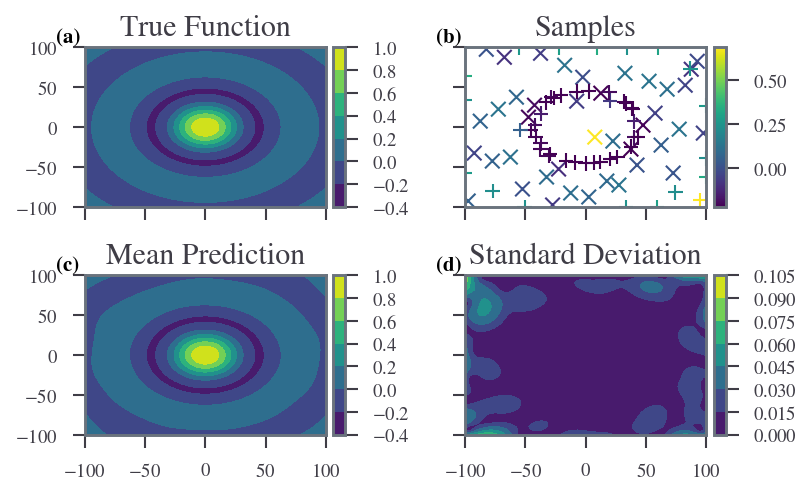

In [51]:
emp = EmulationPreprocess(init_num=40, 
                          active_num=50,
                          acqusition_class=ExpectedImprovement,
                          loop_class=BayesianOptimizationLoop)
emp.plot()

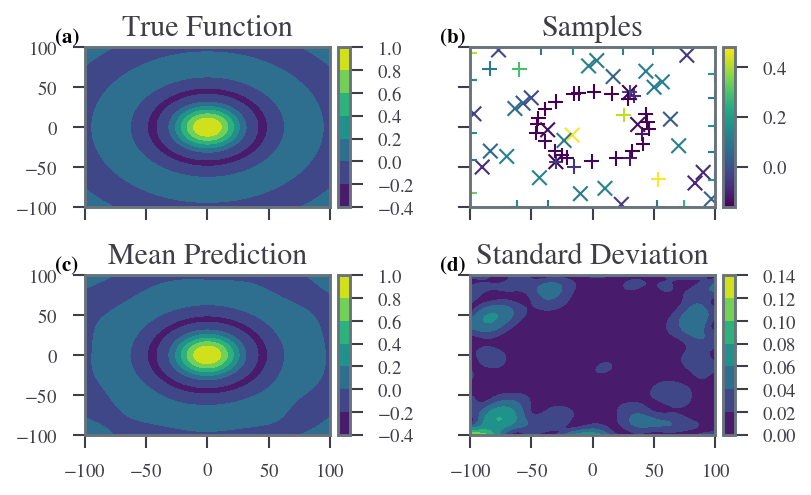

In [52]:
emp = EmulationPreprocess(init_num=30, 
                          active_num=50,
                          acqusition_class=ExpectedImprovement,
                          loop_class=BayesianOptimizationLoop)
emp.plot()

## Markdown

In [53]:
import shutil
from typing import Callable
from sithom.time import timeit


@np.vectorize
def indices_in_bbox(lon, lat):
    return (
        lon > NO_BBOX.lon[0]
        and lon < NO_BBOX.lon[1]
        and lat > NO_BBOX.lat[0]
        and lat < NO_BBOX.lat[1]
    )


@timeit
def func(rmax: float, folder: str, point: Point) -> float:
    output_direc = os.path.join(folder, "a" + "{:.3f}".format(rmax) + "_kat_rmax")
    if os.path.exists(output_direc):
        shutil.rmtree(output_direc)
    ImpactSymmetricTC(
        point=point,
        output_direc=output_direc,
        symetric_model=Holland08(rmax=rmax),
    ).run_impact()
    path = os.path.join(output_direc, "maxele.63.nc")
    maxele = Maxele(path, crs="EPSG:4326")
    index_set = 27
    indices = indices_in_bbox(maxele.x, maxele.y)
    return maxele.values[indices][index_set]


@timeit
def function_sweep() -> Tuple[np.ndarray, np.ndarray]:
    rmax_min = 1e3
    rmax_max = 1e5
    rmaxes = np.linspace(rmax_min, rmax_max, num=1)

    lon_diff = 0.6
    point = Point(NEW_ORLEANS.lon + lon_diff, NEW_ORLEANS.lat)
    folder = os.path.join(DATA_PATH, "kat_emulation3")

    if not os.path.exists(folder):
        os.mkdir(folder)

    height_list = []

    for i in range(len(rmaxes)):
        height_list.append(func(rmaxes[i], folder, point))

    return rmaxes, np.array(height_list)


@timeit
def func_for_emukit() -> Callable:
    lon_diff = 0.6
    point = Point(NEW_ORLEANS.lon + lon_diff, NEW_ORLEANS.lat)
    folder = os.path.join(DATA_PATH, "kat_emulation")

    if not os.path.exists(folder):
        os.mkdir(folder)

    @np.vectorize
    def _func(rmax: float):
        return func(float(rmax), folder, point)

    return _func

In [54]:
function_sweep()

'prepare_run'  12.12239 s 

'prepare_run'  42.72365 s 

'prepare_run'  11.97436 s 

'create_inputs'  01 min 06 s 

'run_adcirc'  04 min 56 s 

'func'  06 min 03 s 

'function_sweep'  06 min 03 s 



(array([1000.]), array([0.56463788]))

In [58]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def fake_function(x1: float, x2: float) -> float:
    return 5 * gaussian(x1, -60, 15) * gaussian(x2, 0.6, 1) 

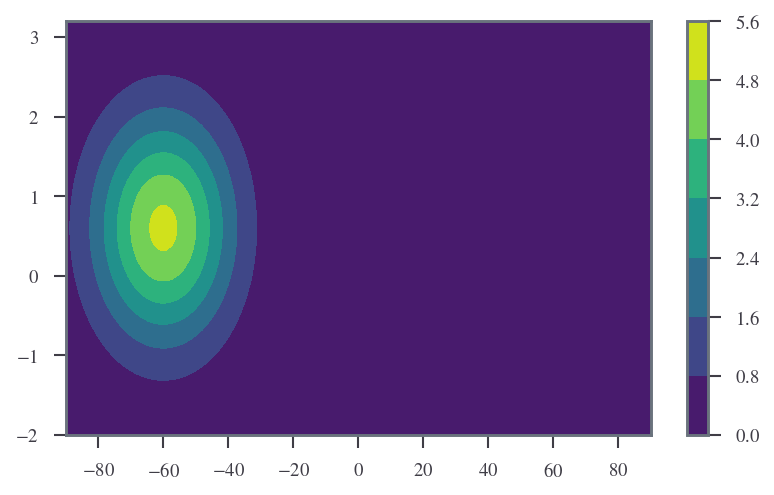

In [59]:
x1 = np.linspace(-90, 90, num=100)
x2 = np.linspace(-2, 3.2, num=100)
x1_mesh, x2_mesh = np.meshgrid(x1, x2)
plt.contourf(x1_mesh, x2_mesh, fake_function(x1_mesh, x2_mesh))
plt.colorbar()

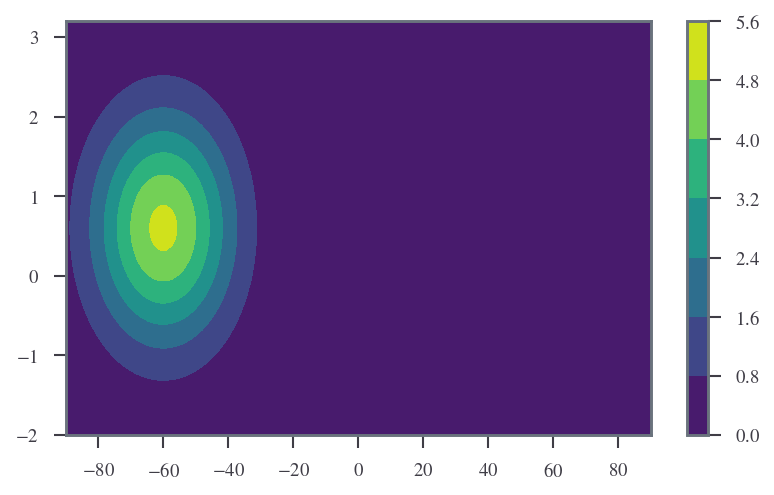

In [94]:
def to_gp_scale(x1, x2):
    return (x1 + 60) / 10, (x2 -0.6) / 0.5

def to_real_scale(x1, x2):
    return x1 * 10 - 60, x2 / 2 + 0.6

def merge(x1, x2):
    return np.concatenate([x1.reshape(*x1.shape, 1), x2.reshape(*x2.shape, 1)], axis=-1)

def split(data):
    shape = data.shape
    if len(shape) == 2:
        return data[:, 0], data[:, 1]
    elif len(shape) == 3:
        return data[:, :, 0], data[:, :, 1]
    else:
        assert False

def fake_gp_function(data) -> float:
    return fake_function(*to_real_scale(*split(data)))

plt.contourf(x1_mesh, x2_mesh, fake_gp_function(merge(*to_gp_scale(x1_mesh, x2_mesh))))
plt.colorbar()

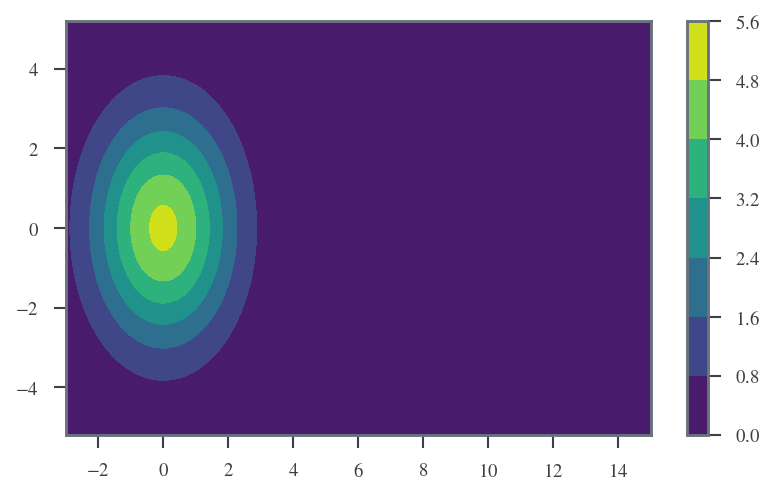

In [95]:
plt.contourf(*to_gp_scale(x1_mesh, x2_mesh), fake_gp_function(merge(*to_gp_scale(x1_mesh, x2_mesh))))
plt.colorbar()

In [81]:
def merge(x1, x2):
    return np.concatenate([x1.reshape(*x1.shape, 1), x2.reshape(*x2.shape, 1)], axis=-1)

In [87]:
def split(data):
    shape = data.shape
    if len(shape) == 2:
        return data[:, 0], data[:, 1]
    elif len(shape) == 3:
        return data[:, :, 0], data[:, :, 1]
    else:
        assert False

In [79]:
x1_mesh.reshape(*x1_mesh.shape, 1).shape

(100, 100, 1)

In [85]:
data = merge(x1_mesh, x2_mesh)
data.shape

(100, 100, 2)

In [91]:
x1, x2 = split(data)
x1.shape
x2.shape

(100, 100)

In [129]:
from sithom.plot import get_dim

In [130]:
?get_dim

In [131]:
class EmulationFake:
    def __init__(
        self,
        seed=0,
        init_num=20,
        active_num=20,
        indices=100,
        acqusition_class=ExpectedImprovement,
        loop_class=ExperimentalDesignLoop,
        x1_range=[-90, 90],
        x2_range=[-2, 3.2],
    ) -> None:
        self.seed = seed
        np.random.seed(seed)
        x1_range, x2_range = self.to_gp_scale(np.array(x1_range), np.array(x2_range))
        x1_range = x1_range.tolist()
        x2_range = x2_range.tolist()
        self.ap = ContinuousParameter("a_param", *x1_range)
        self.bp = ContinuousParameter("b_param", *x2_range)
        self.space = ParameterSpace([self.ap, self.bp])
        self.design = LatinDesign(self.space)
        self.init_num = init_num
        self.active_num = active_num
        self.init_x_data = self.design.get_samples(self.init_num).astype("float32")
        self.init_y_data = self.func(self.init_x_data)
        self.model_gpy = GPRegression(
            self.init_x_data,
            self.init_y_data.reshape(len(self.init_y_data), 1),
            RBF(2, 1),
        )
        self.model_gpy.optimize()

        # active_learning
        self.model_emukit = GPyModelWrapper(self.model_gpy)
        self.acquisition_function = acqusition_class(model=self.model_emukit)
        self.loop = loop_class(
            model=self.model_emukit,
            space=self.space,
            acquisition=self.acquisition_function,
            batch_size=1,
        )
        self.loop.run_loop(self.func, active_num)
        self.active_x_data = self.loop.loop_state.X[len(self.init_x_data) :]
        self.active_y_data = self.loop.loop_state.Y[len(self.init_x_data) :]
        self.indices = indices

    def init_data(self):
        return (
            self.merge(*self.to_real_scale(*self.split(self.init_x_data))),
            self.init_y_data,
        )

    def active_data(self):
        return (
            self.merge(*self.to_real_scale(*self.split(self.active_x_data))),
            self.active_y_data,
        )

    def __repr__(self) -> str:
        return f"seed = {self.seed}, init_num = {self.init_num}, active_num = {self.active_num}"

    def to_gp_scale(self, x1, x2):
        return (x1 + 60) / 10, (x2 - 0.6) / 0.5

    def to_real_scale(self, x1, x2):
        return x1 * 10 - 60, x2 / 2 + 0.6

    def merge(self, x1, x2):
        return np.concatenate(
            [x1.reshape(*x1.shape, 1), x2.reshape(*x2.shape, 1)], axis=-1
        )

    def split(self, data):
        shape = data.shape
        if len(shape) == 2:
            return data[:, 0], data[:, 1]
        elif len(shape) == 3:
            return data[:, :, 0], data[:, :, 1]
        else:
            assert False

    def func(self, data) -> float:
        output = fake_function(*self.to_real_scale(*self.split(data)))
        return output.reshape(len(output), 1)

    def plot(self) -> None:

        a_indices = np.linspace(self.ap.min, self.ap.max, num=self.indices)
        b_indices = np.linspace(self.bp.min, self.bp.max, num=self.indices)
        a_indices, b_indices = to_real_scale(a_indices, b_indices)
        a_mesh, b_mesh = np.meshgrid(a_indices, b_indices)
        length = len(a_indices) * len(b_indices)
        a_array = a_mesh.ravel()
        b_array = b_mesh.ravel()
        comb_array = np.zeros([length, 2])
        comb_array[:, 0] = a_array[:]
        comb_array[:, 1] = b_array[:]
        comb_array_gp = merge(*to_gp_scale(*split(comb_array)))

        # !!! DO NOT EVALUATE FOR REAL FUNCTION !!!
        y_mesh = self.func(comb_array_gp).reshape(self.indices, self.indices)

        # Evaluate Gaussian Process
        mean, var = self.model_emukit.predict(comb_array_gp)
        mean_mesh = mean[:, 0].reshape(self.indices, self.indices)
        std_mesh = np.sqrt(var[:, 0]).reshape(self.indices, self.indices)
        # Evaluate Acquisition Function
        aq_mesh = self.acquisition_function.evaluate(comb_array_gp).reshape(
            self.indices, self.indices
        )
        
        # Set up plot
        plot_defaults()
        fig, axs = plt.subplots(3, 2, sharex=True, sharey=True, figsize=get_dim(ratio=1))
        label_subplots(axs, override="outside")

        ax = axs[0, 0]
        im = ax.contourf(a_mesh, b_mesh, y_mesh)
        ax.set_title("True Function")
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax, orientation="vertical")

        ax = axs[0, 1]
        init_x, init_y = self.init_data()
        active_x, active_y = self.active_data()
        im = ax.scatter(
            init_x[:, 0],
            init_x[:, 1],
            c=init_y,
            marker="x",
            label="original data points",
        )
        ax.scatter(
            active_x[:, 0],
            active_x[:, 1],
            c=active_y,
            marker="+",
            label="new data points",
        )
        divider = make_axes_locatable(ax)
        ax.set_title("Samples")
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax, orientation="vertical")

        ax = axs[1, 0]
        ax.set_title("Mean Prediction")
        im = ax.contourf(a_mesh, b_mesh, mean_mesh, vmin=0, vmax=5.6)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax, orientation="vertical")

        ax = axs[1, 1]
        ax.set_title("GP Standard Deviation")
        im = ax.contourf(a_mesh, b_mesh, std_mesh)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax, orientation="vertical")
        
        ax = axs[2, 1]
        ax.set_title("Aqcuisition Function")
        im = ax.contourf(a_mesh, b_mesh, aq_mesh)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax, orientation="vertical")
        
        ax = axs[2, 0]
        ax.set_title("Difference from True")
        im = ax.contourf(a_mesh, b_mesh, mean_mesh - y_mesh)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax, orientation="vertical")    
        plt.show()
        

In [132]:
em = EmulationFake()

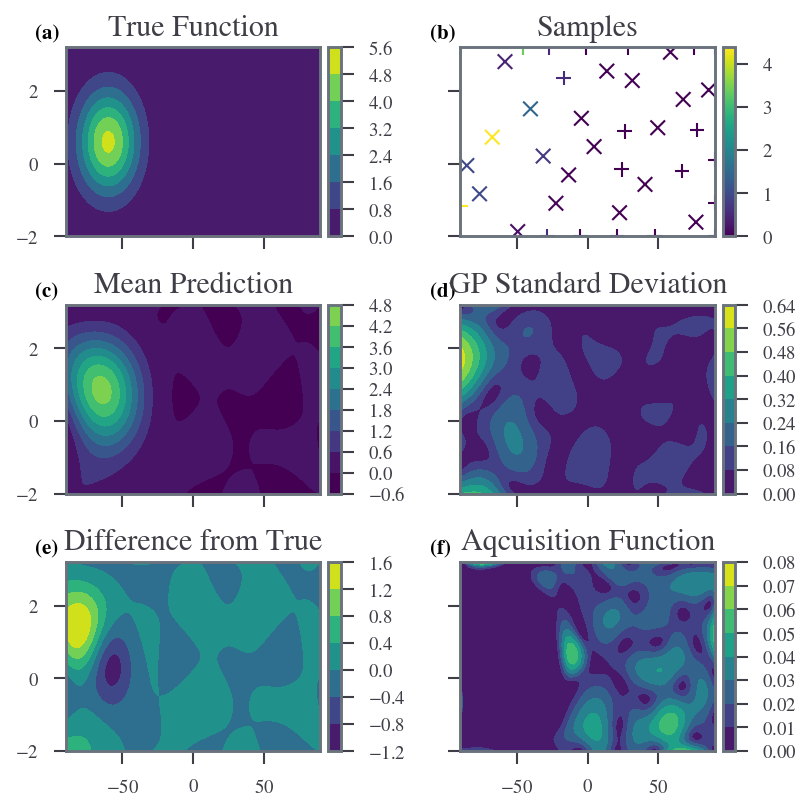

In [133]:
em.plot()

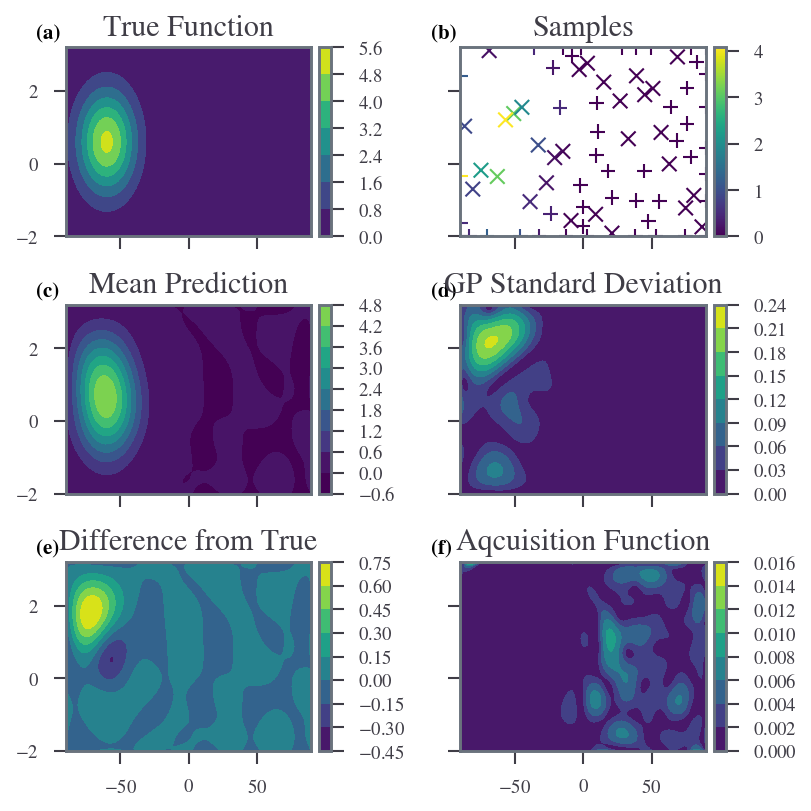

In [134]:
em = EmulationFake(init_num=30, active_num=50)
em.plot()

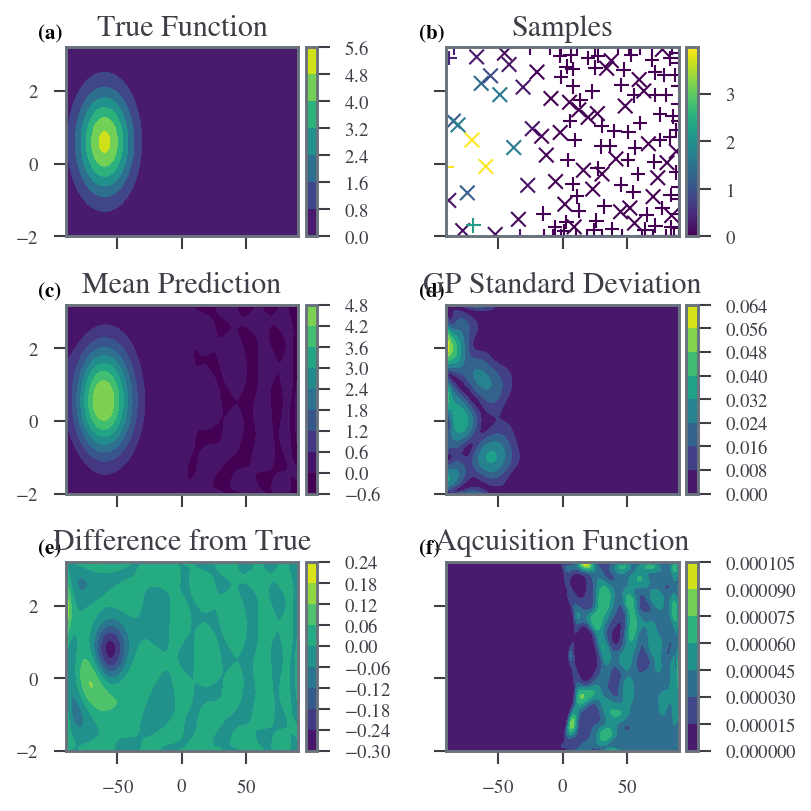

In [135]:
em = EmulationFake(init_num=50, active_num=100)
em.plot()

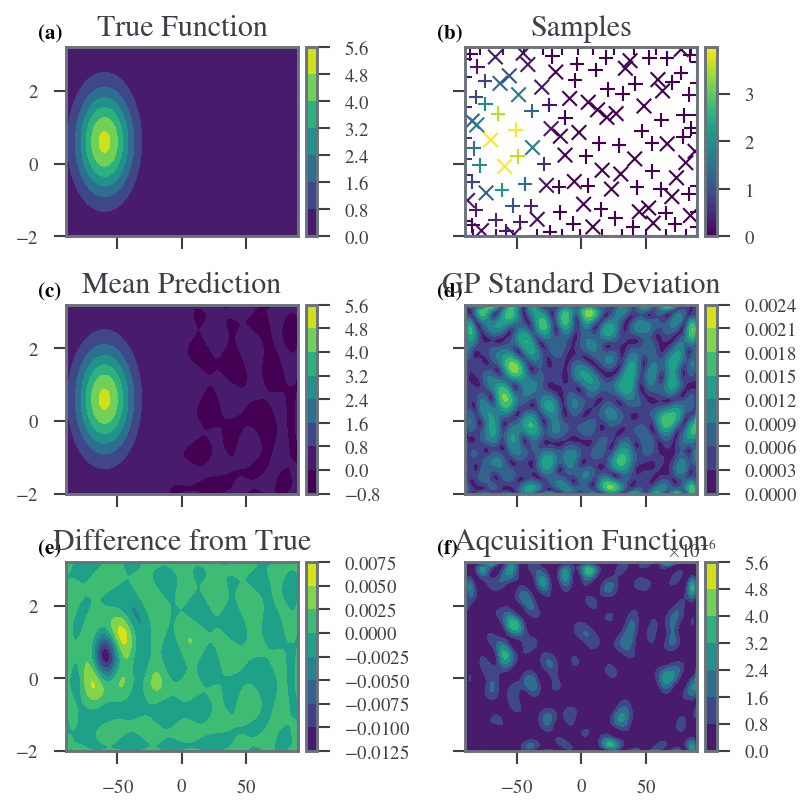

In [136]:
em = EmulationFake(init_num=50, active_num=100, acqusition_class=ModelVariance, loop_class=BayesianOptimizationLoop)
em.plot()

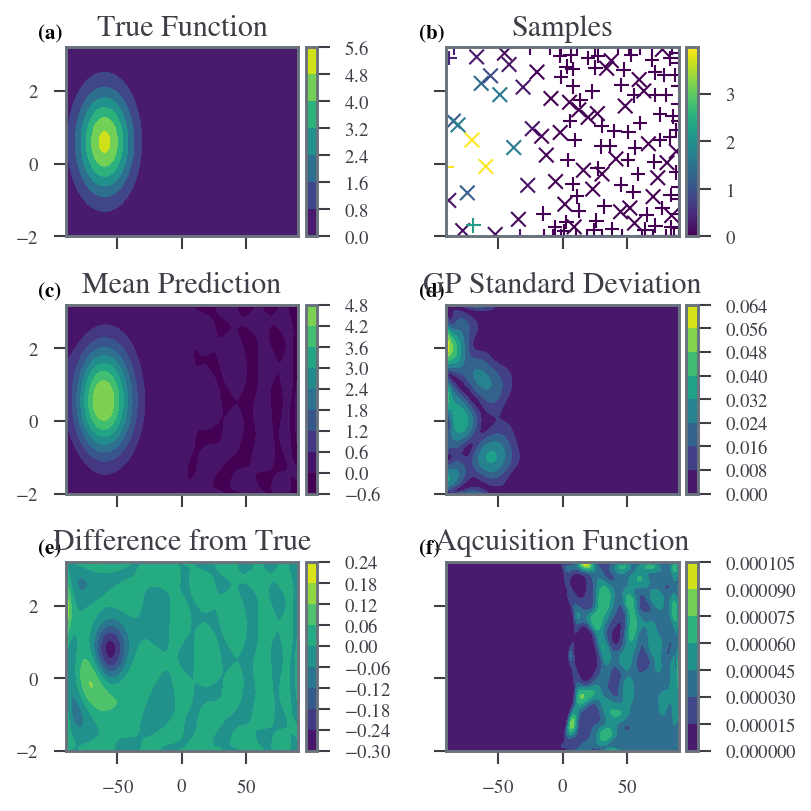

In [137]:
em = EmulationFake(
    init_num=50,
    active_num=100,
    acqusition_class=ExpectedImprovement,
    loop_class=ExperimentalDesignLoop,
)
em.plot()